<a href="https://colab.research.google.com/github/mjoeli/MSc_/blob/main/lr_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns
import re
from glob import glob
import os
import random
import csv

import statsmodels.api as sm
from scipy import stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [ ]:
inputdir = './drive/MyDrive/master_thesis/LinearReg_output'
outdir = './drive/MyDrive/master_thesis/CV_LR_output'
outdir_plot = './drive/MyDrive/master_thesis/plots'

In [ ]:
n_folds = 10
train_data_per_fold = [[] for _ in range(n_folds)]
combined_Xtest_per_fold = []
combined_ytest_per_fold = []
combined_Xtrain_per_fold = []
combined_ytrain_per_fold = []
regions = ['nE', 'wE', 'sE', 'eE', 'wA']

for i in range(n_folds):
    combined_Xtest = {'OA': [], 'age': [], 'female': []}
    combined_ytest = {'casp': []}
    combined_Xtrain = {'OA': [], 'age': [], 'female': []}
    combined_ytrain = {'casp': []}

    for region in regions:
        Xtrain_dir = os.path.join(inputdir, f'fold_{i+1}_Xtrain_{region}.csv')
        ytrain_dir = os.path.join(inputdir, f'fold_{i+1}_ytrain_{region}.csv')
        Xtest_dir = os.path.join(inputdir, f'fold_{i+1}_Xtest_{region}.csv')
        ytest_dir = os.path.join(inputdir, f'fold_{i+1}_ytest_{region}.csv')

        # Load the data from CSV files
        X_train_region = pd.read_csv(Xtrain_dir)
        y_train_region = pd.read_csv(ytrain_dir)

        train_data = pd.concat([X_train_region, y_train_region], axis=1)
        train_data.to_csv(os.path.join(outdir, f'train_fold{i+1}_{region}.csv'), index=False, header=True, sep=',')

        X_test_region = pd.read_csv(Xtest_dir)
        y_test_region = pd.read_csv(ytest_dir)

        # All regions per fold
        train_data_per_fold[i].append((X_train_region, y_train_region))

        # Combine test data of all regions per fold
        combined_Xtest['OA'].extend(X_test_region['OA'])
        combined_Xtest['age'].extend(X_test_region['age'])
        combined_Xtest['female'].extend(X_test_region['female'])
        combined_ytest['casp'].extend(y_test_region['casp'])

        # Combine train data of all regions per fold for CL
        combined_Xtrain['OA'].extend(X_train_region['OA'])
        combined_Xtrain['age'].extend(X_train_region['age'])
        combined_Xtrain['female'].extend(X_train_region['female'])
        combined_ytrain['casp'].extend(y_train_region['casp'])

        # Append all train data
        #train_data_per_fold.append((X_train_region, y_train_region))
        #test_data_per_fold.append((Xtest_dir, ytest_dir))

    # Append the combined test data
    combined_Xtest_per_fold.append(combined_Xtest)
    combined_ytest_per_fold.append(combined_ytest)

    #save global test set
    test_data = pd.concat([pd.DataFrame(combined_Xtest_per_fold[i]), pd.DataFrame(combined_ytest_per_fold[i])], axis=1)
    test_data.to_csv(os.path.join(outdir, f'test_fold{i+1}.csv'), index=False, header=True, sep=',')

    # Append the combined train data
    combined_Xtrain_per_fold.append(combined_Xtrain)
    combined_ytrain_per_fold.append(combined_ytrain)

LR - Central

In [ ]:
lr_models = []
CL_test_results = []
CL_intercepts = []
CL_coefficients = []

for i in range(n_folds):
  Xtrain = pd.DataFrame(combined_Xtrain_per_fold[i])
  ytrain = pd.DataFrame(combined_ytrain_per_fold[i])
  Xtest = pd.DataFrame(combined_Xtest_per_fold[i])
  ytest = pd.DataFrame(combined_ytest_per_fold[i])

  lr_model = LinearRegression()
  lr_model.fit(Xtrain, ytrain)

  y_pred = lr_model.predict(Xtest)
  r_squared = r2_score(ytest, y_pred)
  CL_test_results.append(r_squared)
  CL_intercepts.append(float(lr_model.intercept_))
  CL_coefficients.append(float(lr_model.coef_[0][0]))

print(f'Average R-squared = {np.mean(r_squared)}')
print(f'Average Intercept = {np.mean(CL_intercepts)}')
#stack_coef = np.stack(coefficients, axis=0)
#avg_coef = np.mean(stack_coef[:, :, 0])
print(f'Average Coefficient = {np.mean(CL_coefficients)}')

Average R-squared = 0.04858172486218493
Average Intercept = 46.359914560893976
Average Coefficient = -1.2119412644938659


In [ ]:
result_data = list(zip(CL_test_results, CL_intercepts, CL_coefficients))
csv_filename = os.path.join(outdir, f'result_CL.csv')

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Test_Result', 'Intercept', 'Coefficients'])
    writer.writerows(result_data)

print(f'File saved in {csv_filename}')

File saved in ./drive/MyDrive/master_thesis/CV_LR_output/result_CL.csv


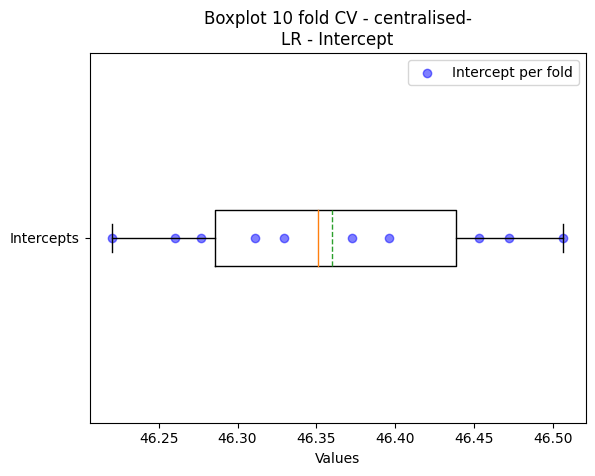

In [ ]:
plt.boxplot(CL_intercepts, vert=False, labels=['Intercepts'], showmeans=True, meanline=True)

# Add fold sepcific values
plt.scatter(CL_intercepts, [1] * len(CL_intercepts), color='blue', label='Intercept per fold', alpha=0.5)

plt.title("Boxplot 10 fold CV - centralised-\nLR - Intercept")
plt.xlabel("Values")
plt.legend()
plt.savefig(os.path.join(outdir_plot, 'Boxplot_Coefs_age_unbalanced.png'))

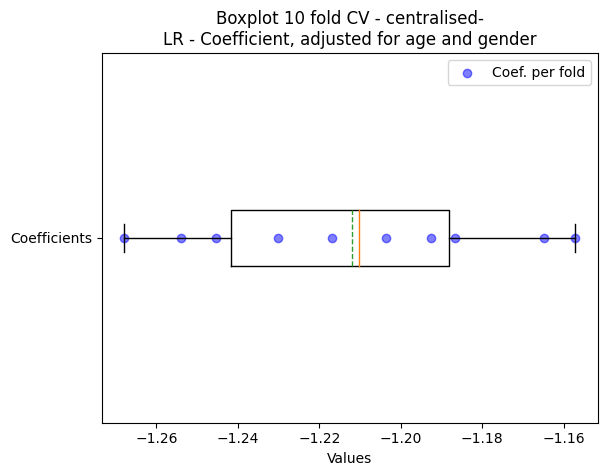

In [ ]:
plt.boxplot(CL_coefficients, vert=False, labels=['Coefficients'], showmeans=True, meanline=True)

# Add fold sepcific values
plt.scatter(CL_coefficients, [1] * len(CL_coefficients), color='blue', label='Coef. per fold', alpha=0.5)

plt.title("Boxplot 10 fold CV - centralised-\nLR - Coefficient, adjusted for age and gender")
plt.xlabel("Values")
plt.legend()

LR - Region

In [ ]:
lr_models = []
test_results = []
intercepts = []
coefficients = []
total_weight = 0

plotdata = {
    'Region': [],
    'Intercept': [],
    'Coeff_OA': [],
    'Coeff_age': [],
    'Coeff_female': []
}

for i in range(n_folds):
    combined_Xtest = combined_Xtest_per_fold[i]
    combined_ytest = combined_ytest_per_fold[i]

    for region in regions:
        X_train_region, y_train_region = train_data_per_fold[i][regions.index(region)]

        local_weight = X_train_region.shape[0]
        total_weight += local_weight

        feature_names = X_train_region.columns.tolist()

        lr_model = LinearRegression()
        lr_model.fit(X_train_region, y_train_region)

        X_test = {name: combined_Xtest[name] for name in feature_names}
        y_pred = lr_model.predict(pd.DataFrame(X_test))
        #y_pred = lr_model.predict(np.array([combined_Xtest['OA'], combined_Xtest['age'], combined_Xtest['female']]).T)
        r_squared = r2_score(combined_ytest['casp'], y_pred)

        test_results.append(r_squared)
        intercepts.append(lr_model.intercept_ * local_weight)
        coefficients.append(lr_model.coef_ * local_weight)

        plotdata['Region'].append(region)
        plotdata['Intercept'].append(lr_model.intercept_[0])
        coef = lr_model.coef_[0]  # Coefficients as a 1D array
        plotdata['Coeff_OA'].append(coef[0])
        plotdata['Coeff_age'].append(coef[1])
        plotdata['Coeff_female'].append(coef[2])

weighted_avg_intercept = sum(intercepts) / total_weight
coef = [coef[0] for coef in coefficients]
weighted_avg_coef = sum(coef) / total_weight

print(f'R-squared = {np.mean(test_results)}')
print(f'Weighted Average Intercept = {weighted_avg_intercept}')
print(f'Weighted Average Coefficient = {weighted_avg_coef}')

R-squared = -0.03717909533614205
Weighted Average Intercept = [46.42661277]
Weighted Average Coefficient = [-1.6521638  -0.11986983 -0.51751524]


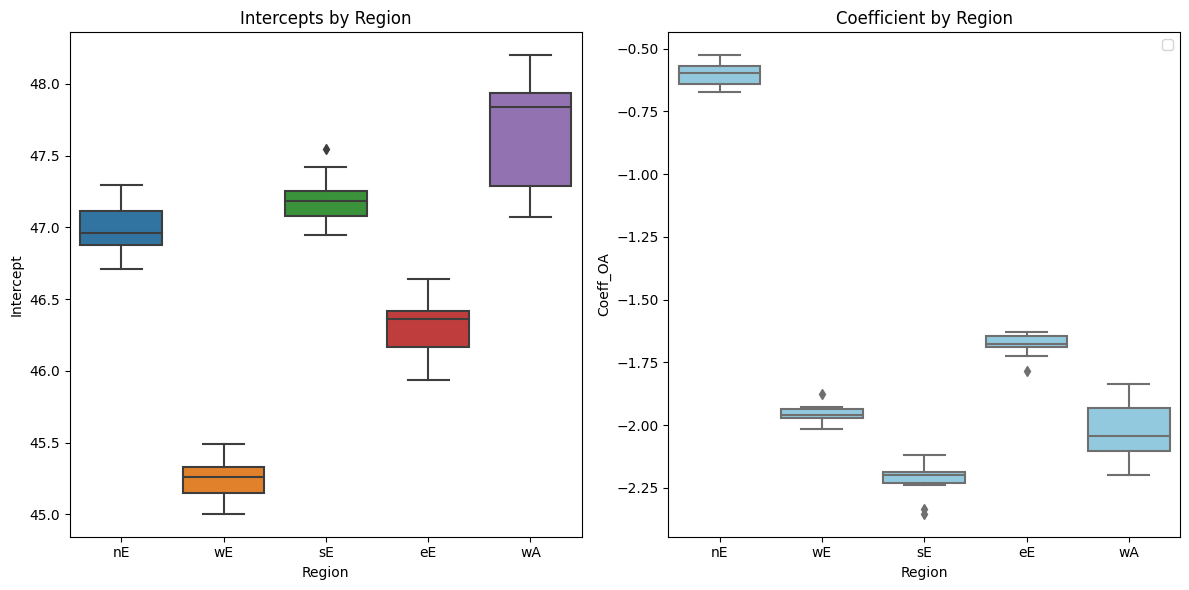

In [ ]:
df = pd.DataFrame(plotdata)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Region', y='Intercept', data=df)
plt.title('Intercepts by Region')

plt.subplot(1, 2, 2)
sns.boxplot(x='Region', y='Coeff_OA', data=df, color='skyblue')
plt.legend(loc='upper right')
plt.title('Coefficient by Region')

plt.tight_layout()
plt.show()

In [ ]:
result_data = list(zip(test_results, intercepts, coefficients))
csv_filename = os.path.join(outdir, f'result_region_data.csv')

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Test_Result', 'Intercept', 'Coefficients'])
    writer.writerows(result_data)

print(f'File saved in {csv_filename}')

File saved in ./drive/MyDrive/master_thesis/CV_LR_output/result_region_data.csv


LR - Region - short

In [ ]:
n_folds = 10
train_data_per_fold = [[] for _ in range(n_folds)]
combined_Xtest_per_fold = []
combined_ytest_per_fold = []
combined_Xtrain_per_fold = []
combined_ytrain_per_fold = []
regions = ['nE', 'wE', 'sE', 'eE', 'wA']

for i in range(n_folds):
    combined_Xtest = {'OA': [], 'age': [], 'female': []}
    combined_ytest = {'casp': []}
    combined_Xtrain = {'OA': [], 'age': [], 'female': []}
    combined_ytrain = {'casp': []}

    for region in regions:
        Xtrain_dir = os.path.join(inputdir, f'fold_{i+1}_Xtrain_{region}_short.csv')
        ytrain_dir = os.path.join(inputdir, f'fold_{i+1}_ytrain_{region}_short.csv')
        Xtest_dir = os.path.join(inputdir, f'fold_{i+1}_Xtest_{region}_short.csv')
        ytest_dir = os.path.join(inputdir, f'fold_{i+1}_ytest_{region}_short.csv')

        # Load the data from CSV files
        X_train_region = pd.read_csv(Xtrain_dir)
        y_train_region = pd.read_csv(ytrain_dir)

        train_data = pd.concat([X_train_region, y_train_region], axis=1)
        train_data.to_csv(os.path.join(outdir, f'train_fold{i+1}_{region}_short.csv'), index=False, header=True, sep=',')

        X_test_region = pd.read_csv(Xtest_dir)
        y_test_region = pd.read_csv(ytest_dir)

        # All regions per fold
        train_data_per_fold[i].append((X_train_region, y_train_region))

        # Combine test data of all regions per fold
        combined_Xtest['OA'].extend(X_test_region['OA'])
        combined_Xtest['age'].extend(X_test_region['age'])
        combined_Xtest['female'].extend(X_test_region['female'])
        combined_ytest['casp'].extend(y_test_region['casp'])

        # Combine train data of all regions per fold for CL
        combined_Xtrain['OA'].extend(X_train_region['OA'])
        combined_Xtrain['age'].extend(X_train_region['age'])
        combined_Xtrain['female'].extend(X_train_region['female'])
        combined_ytrain['casp'].extend(y_train_region['casp'])

        # Append all train data
        #train_data_per_fold.append((X_train_region, y_train_region))
        #test_data_per_fold.append((Xtest_dir, ytest_dir))

    # Append the combined test data
    combined_Xtest_per_fold.append(combined_Xtest)
    combined_ytest_per_fold.append(combined_ytest)

    #save global test set
    test_data = pd.concat([pd.DataFrame(combined_Xtest_per_fold[i]), pd.DataFrame(combined_ytest_per_fold[i])], axis=1)
    test_data.to_csv(os.path.join(outdir, f'test_fold{i+1}_short.csv'), index=False, header=True, sep=',')

    # Append the combined train data
    combined_Xtrain_per_fold.append(combined_Xtrain)
    combined_ytrain_per_fold.append(combined_ytrain)

In [ ]:
lr_models = []
test_results = []
intercepts = []
coefficients = []
total_weight = 0

plotdata = {
    'Region': [],
    'Intercept': [],
    'Coeff_OA': [],
    'Coeff_age': [],
    'Coeff_female': []
}

for i in range(n_folds):
    combined_Xtest = combined_Xtest_per_fold[i]
    combined_ytest = combined_ytest_per_fold[i]

    for region in regions:
        X_train_region, y_train_region = train_data_per_fold[i][regions.index(region)]
        feature_names = X_train_region.columns.tolist()

        local_weight = X_train_region.shape[0]
        total_weight += local_weight

        lr_model = LinearRegression()
        lr_model.fit(X_train_region, y_train_region)

        X_test_region = {name: combined_Xtest[name] for name in feature_names}
        y_pred = lr_model.predict(pd.DataFrame(X_test_region))
        #y_pred = lr_model.predict(np.array([combined_Xtest['OA'], combined_Xtest['age'], combined_Xtest['female']]).T)
        r_squared = r2_score(combined_ytest['casp'], y_pred)
        test_results.append(r_squared * local_weight)
        intercepts.append(lr_model.intercept_ * local_weight)
        coefficients.append(lr_model.coef_ * local_weight)

        plotdata['Region'].append(region)
        plotdata['Intercept'].append(lr_model.intercept_[0])
        coef = lr_model.coef_[0]  # Coefficients as a 1D array
        plotdata['Coeff_OA'].append(coef[0])
        plotdata['Coeff_age'].append(coef[1])
        plotdata['Coeff_female'].append(coef[2])


weighted_avg_r2 = sum(test_results) / total_weight
weighted_avg_intercept = sum(intercepts) / total_weight
coef = [coef[0] for coef in coefficients]
weighted_avg_coef = sum(coef) / total_weight

print(f'Weighted Average R-squared = {weighted_avg_r2}')
print(f'Weighted Average Intercept = {weighted_avg_intercept}')
print(f'Weighted Average Coefficient = {weighted_avg_coef}')

Weighted Average R-squared = 0.026919936236919923
Weighted Average Intercept = [46.65116598]
Weighted Average Coefficient = [-1.10868026 -0.12351238 -0.57773316]


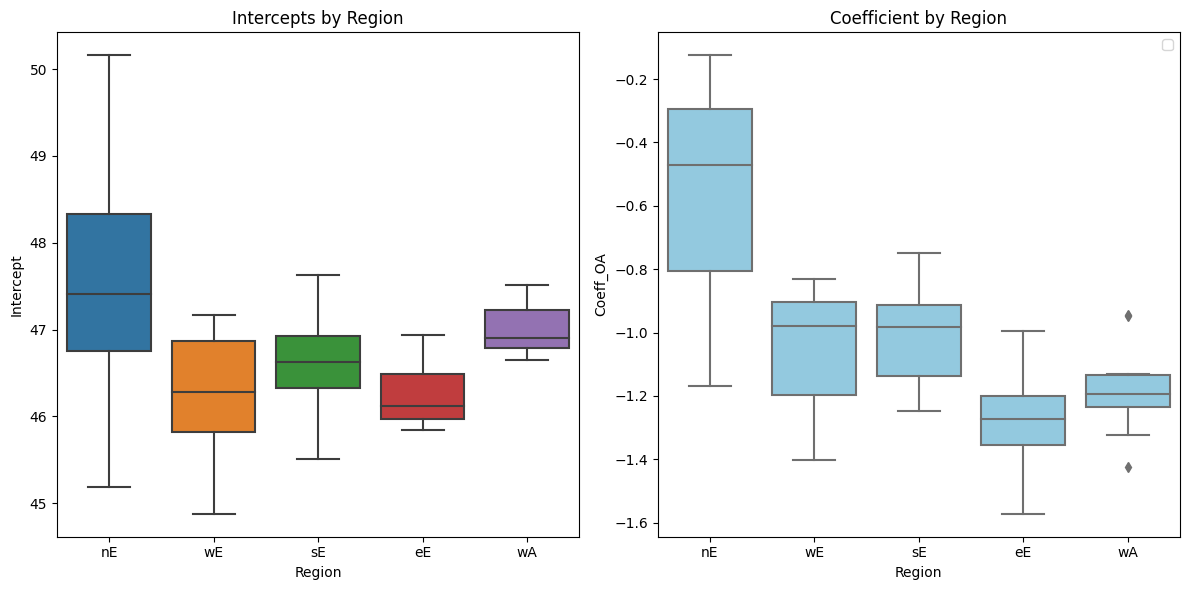

In [ ]:
df = pd.DataFrame(plotdata)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Region', y='Intercept', data=df)
plt.title('Intercepts by Region')

plt.subplot(1, 2, 2)
sns.boxplot(x='Region', y='Coeff_OA', data=df, color='skyblue')
plt.legend(loc='upper right')
plt.title('Coefficient by Region')

plt.tight_layout()
plt.show()

In [ ]:
result_data = list(zip(test_results, intercepts, coefficients))
csv_filename = os.path.join(outdir, f'result_region_short_data.csv')

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Test_Result', 'Intercept', 'Coefficients'])
    writer.writerows(result_data)

print(f'File saved in {csv_filename}.')

File saved in ./drive/MyDrive/master_thesis/CV_LR_output/result_region_short_data.csv.


FL plots

In [ ]:
#loading FL results random
file_path = './drive/MyDrive/master_thesis/FL_random.txt'

FL_r2_rand = []
FL_intercepts_rand = []
FL_coefs_rand = []

# Open the txt file for reading
with open(file_path, 'r') as file:
    lines = file.readlines()
for line in lines:
    if 'FL_r2' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL_r2_rand = [float(value) for value in values if value]
    elif 'FL_intercepts' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL_intercepts_rand = [float(value) for value in values if value]
    elif 'FL_coefs' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL_coefs_rand = [float(value) for value in values if value]

print("FL_r2:", FL_r2_rand)
print("FL_intercepts:", FL_intercepts_rand)
print("FL_intercepts mean:", np.mean(FL_intercepts_rand))
print("FL_intercepts std per fold:", np.std(FL_intercepts_rand))
print("FL_coefs:", FL_coefs_rand)
print("FL_coefs mean:", np.mean(FL_coefs_rand))
print("FL_coefs std per fold:", np.std(FL_coefs_rand))

FL_intercept = np.mean(FL_intercepts_rand)
FL_coef = np.mean(FL_coefs_rand)

FL_r2: [0.04697901594779308, 0.03926186377655505, 0.050582659838436794, 0.04239741523354612, 0.03841246840370638, 0.02895720104703392, 0.038511555017245236, 0.03144918817649678, 0.04877613988784557, 0.048578608856567396]
FL_intercepts: [46.25810888871096, 46.45440501799671, 46.30946052325319, 46.22322503003942, 46.39734488403459, 46.507174391269345, 46.369966627987644, 46.47582995127002, 46.27936030356693, 46.324106382164686]
FL_intercepts mean: 46.35989820002935
FL_intercepts std per fold: 0.09215074552261478
FL_coefs: [-1.18584622, -1.16517636, -1.1562314, -1.26846723, -1.21736033, -1.22831303, -1.25783752, -1.24526473, -1.20458197, -1.19244694]
FL_coefs mean: -1.212152573
FL_coefs std per fold: 0.0362142836563492


In [ ]:
#loading FL results per region
file_path = './drive/MyDrive/master_thesis/FL_region.txt'

FL_r2 = []
FL_intercepts = []
FL_coefs = []

# Open the txt file for reading
with open(file_path, 'r') as file:
    lines = file.readlines()
for line in lines:
    if 'FL_r2' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL_r2 = [float(value) for value in values if value]
    elif 'FL_intercepts' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL_intercepts = [float(value) for value in values if value]
    elif 'FL_coefs' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL_coefs = [float(value) for value in values if value]

print("FL_r2:", FL_r2)
print("FL_intercepts:", FL_intercepts)
print("FL_intercepts mean:", np.mean(FL_intercepts))
print("FL_intercepts std per fold:", np.std(FL_intercepts))
print("FL_coefs:", FL_coefs)
print("FL_coefs mean:", np.mean(FL_coefs))
print("FL_coefs std per fold:", np.std(FL_coefs))

FL_intercept = np.mean(FL_intercepts)
FL_coef = np.mean(FL_coefs)

FL_r2: [0.04723419, 0.039934938, 0.05169393, 0.040275951, 0.03717571, 0.027367554, 0.036447296, 0.029448825, 0.048027955, 0.048519266]
FL_intercepts: [46.3131708826162, 46.54132333, 46.42843986, 46.27955276, 46.43038046, 46.58001434, 46.44710989, 46.50381607, 46.34304809, 46.3992724]
FL_intercepts mean: 46.42661280826162
FL_intercepts std per fold: 0.09236602697344337
FL_coefs: [-1.609735, -1.615106, -1.623204, -1.686235, -1.649181, -1.669277, -1.696158, -1.694547, -1.643372, -1.634822]
FL_coefs mean: -1.6521636999999998
FL_coefs std per fold: 0.0309590343132663


In [ ]:
#loading FL results per region (same amount of data)
file_path = './drive/MyDrive/master_thesis/FL_region_short.txt'

FL1_r2 = []
FL1_intercepts = []
FL1_coefs = []

# Open the txt file for reading
with open(file_path, 'r') as file:
    lines = file.readlines()
for line in lines:
    if 'FL_r2' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL1_r2 = [float(value) for value in values if value]
    elif 'FL_intercepts' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL1_intercepts = [float(value) for value in values if value]
    elif 'FL_coefs' in line:
        values = line.split('=')[1].strip().strip('[]').split(', ')
        FL1_coefs = [float(value) for value in values if value]

print("FL_r2:", FL1_r2)
print("FL_intercepts:", FL1_intercepts)
print("FL_intercepts mean:", np.mean(FL1_intercepts))
print("FL_intercepts std per fold:", np.std(FL1_intercepts))
print("FL_coefs:", FL1_coefs)
print("FL_coefs mean:", np.mean(FL1_coefs))
print("FL_coefs std per fold:", np.std(FL1_coefs))

FL1_intercept = np.mean(FL1_intercepts)
FL1_coef = np.mean(FL1_coefs)

FL_r2: [0.03722544, 0.034596098, 0.041111472, 0.03744312, 0.033332706, 0.02095858, 0.035066183, 0.025017122, 0.04756148, 0.046955671]
FL_intercepts: [46.53936258, 45.95710663, 47.42531646, 46.23990629, 46.4852709, 46.88750268, 47.31459803, 46.65847507, 46.51919306, 46.48591278]
FL_intercepts mean: 46.651264448
FL_intercepts std per fold: 0.4278970642269151
FL_coefs: [-1.292744, -1.387291, -0.863771, -1.113682, -1.07447, -1.27669, -1.08031, -0.889246, -1.078354, -1.029618]
FL_coefs mean: -1.1086176
FL_coefs std per fold: 0.16032259115308736


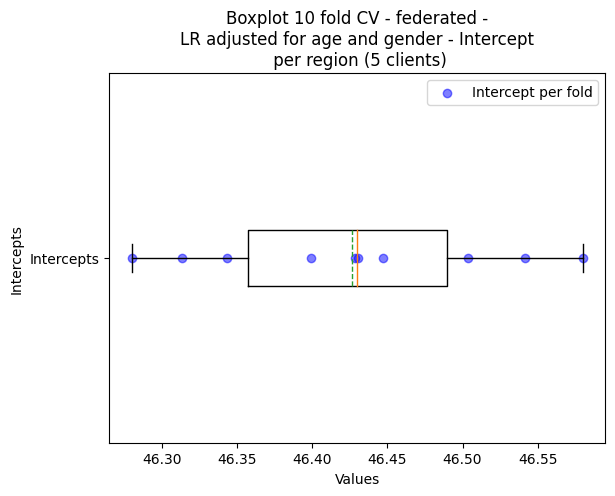

In [ ]:
plt.boxplot(FL_intercepts, vert=False, labels=['Intercepts'], showmeans=True, meanline=True)

# Add individual data points as a scatter plot
plt.scatter(FL_intercepts, [1] * len(FL_intercepts), color='blue', label='Intercept per fold', alpha=0.5)

plt.title("Boxplot 10 fold CV - federated -\nLR adjusted for age and gender - Intercept\n per region (5 clients)")

plt.xlabel("Values")
plt.ylabel("Intercepts")
plt.legend()

# Show the plot
plt.show()

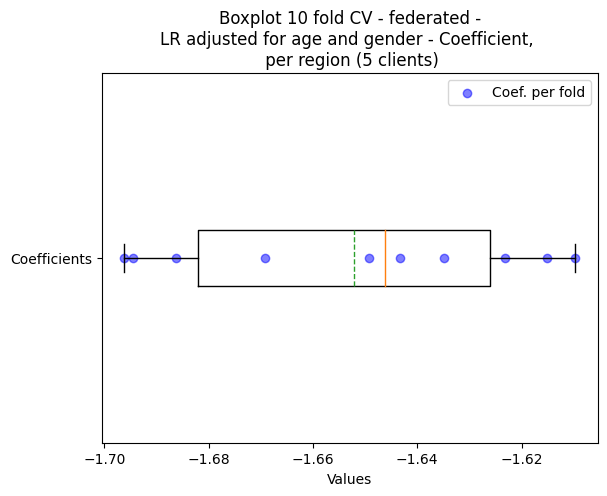

In [ ]:

plt.boxplot(FL_coefs, vert=False, labels=['Coefficients'], showmeans=True, meanline=True)

# Add fold sepcific values
plt.scatter(FL_coefs, [1] * len(FL_coefs), color='blue', label='Coef. per fold', alpha=0.5)


plt.title("Boxplot 10 fold CV - federated -\nLR adjusted for age and gender - Coefficient, \n per region (5 clients)")
plt.xlabel("Values")
#plt.ylabel("Coefficient")
plt.legend()
plt.show()

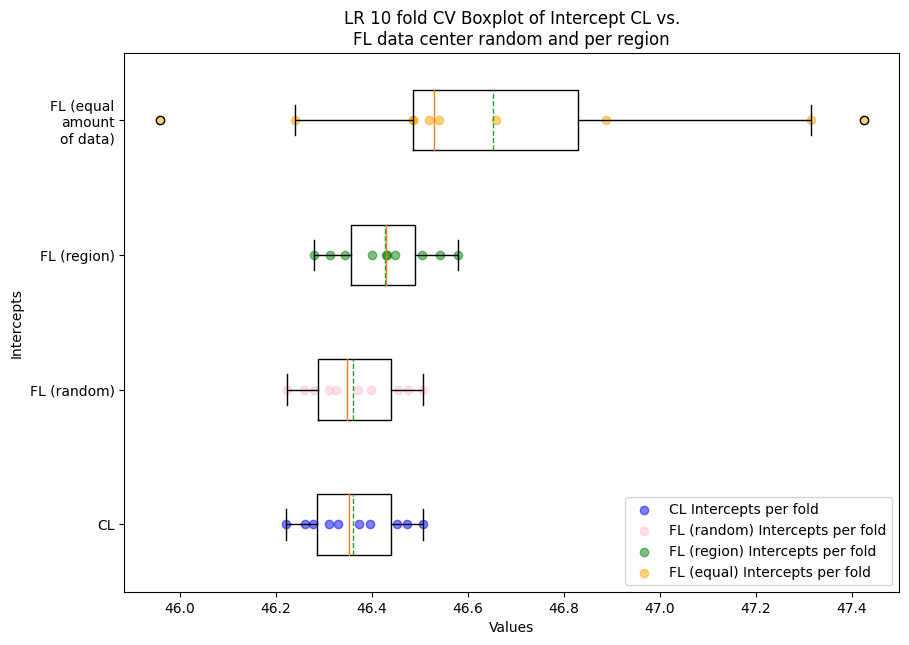

In [ ]:
plt.figure(figsize=(10, 7))
plt.boxplot([CL_intercepts, FL_intercepts_rand, FL_intercepts, FL1_intercepts], vert=False, labels=['CL', 'FL (random)', 'FL (region)', 'FL (equal\namount\nof data)'], showmeans=True, meanline=True)
plt.scatter(CL_intercepts, [1] * len(CL_intercepts), color='blue', label='CL Intercepts per fold', alpha=0.5)
plt.scatter(FL_intercepts_rand, [2] * len(CL_intercepts), color='pink', label='FL (random) Intercepts per fold', alpha=0.5)
plt.scatter(FL_intercepts, [3] * len(FL_intercepts), color='green', label='FL (region) Intercepts per fold', alpha=0.5)
plt.scatter(FL1_intercepts, [4] * len(FL1_intercepts), color='orange', label='FL (equal) Intercepts per fold', alpha=0.5)
plt.title("LR 10 fold CV Boxplot of Intercept CL vs.\nFL data center random and per region")
plt.xlabel("Values")
plt.ylabel("Intercepts")
plt.legend(loc='lower right')
plt.savefig(os.path.join(outdir_plot, 'Boxplot_Intercept_Region.png'))
plt.show()

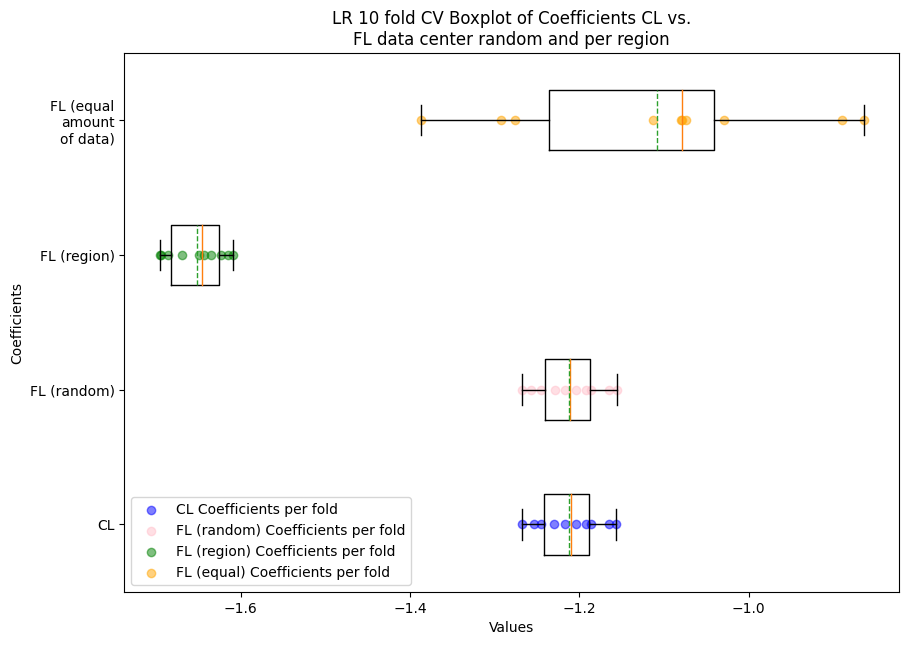

In [ ]:
plt.figure(figsize=(10, 7))
plt.boxplot([CL_coefficients, FL_coefs_rand, FL_coefs, FL1_coefs], vert=False, labels=['CL', 'FL (random)', 'FL (region)', 'FL (equal\namount\nof data)'], showmeans=True, meanline=True)
plt.scatter(CL_coefficients, [1] * len(CL_coefficients), color='blue', label='CL Coefficients per fold', alpha=0.5)
plt.scatter(FL_coefs_rand, [2] * len(CL_coefficients), color='pink', label='FL (random) Coefficients per fold', alpha=0.5)
plt.scatter(FL_coefs, [3] * len(FL_coefs), color='green', label='FL (region) Coefficients per fold', alpha=0.5)
plt.scatter(FL1_coefs, [4] * len(FL1_coefs), color='orange', label='FL (equal) Coefficients per fold', alpha=0.5)
plt.title("LR 10 fold CV Boxplot of Coefficients CL vs.\nFL data center random and per region")
plt.xlabel("Values")
plt.ylabel("Coefficients")
plt.legend(loc='lower left')
plt.savefig(os.path.join(outdir_plot, 'Boxplot_Coef_Region.png'))
plt.show()

UNBALANCED DATA - AGE

In [ ]:
def load_FL_data(file_path):
    FL_age_r2 = []
    FL_age_intercepts = []
    FL_age_coefs = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        if 'FL_r2' in line:
            values = line.split('=')[1].strip().strip('[]').split(', ')
            FL_age_r2 = [float(value) for value in values if value]
        elif 'FL_intercepts' in line:
            values = line.split('=')[1].strip().strip('[]').split(', ')
            FL_age_intercepts = [float(value) for value in values if value]
        elif 'FL_coefs' in line:
            values = line.split('=')[1].strip().strip('[]').split(', ')
            FL_age_coefs = [float(value) for value in values if value]

    return FL_age_r2, FL_age_intercepts, FL_age_coefs


def plot_boxplot(para_list, labels, ylabel, outdir, title, legend_loc, legend_label, save_img):
    plt.figure(figsize=(10, 7))
    boxplot = plt.boxplot(para_list, vert=False, labels=labels, showmeans=True, meanline=True)

    for i, para in enumerate(para_list):
        plt.scatter(para, [i+1] * len(para), alpha=0.5, label=f'{legend_label[i]} {ylabel} per fold')

    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel(ylabel)
    plt.legend(loc=legend_loc)
    plt.savefig(os.path.join(outdir, save_img))
    plt.show()


In [ ]:
r2_2c, intercept_2c, coef_2c = load_FL_data('./drive/MyDrive/master_thesis/FL_age_2c.txt')
print("FL_r2:", np.mean(r2_2c))
print("FL Intercept:", np.mean(intercept_2c))
print("FL coef:", np.mean(coef_2c))

r2_3c, intercept_3c, coef_3c = load_FL_data('./drive/MyDrive/master_thesis/FL_age_3c.txt')
print("FL_r2:", np.mean(r2_3c))
print("FL Intercept:", np.mean(intercept_3c))
print("FL coef:", np.mean(coef_3c))

r2_4c, intercept_4c, coef_4c = load_FL_data('./drive/MyDrive/master_thesis/FL_age_4c.txt')
print("FL_r2:", np.mean(r2_4c))
print("FL Intercept:", np.mean(intercept_4c))
print("FL coef:", np.mean(coef_4c))

FL_r2: 0.02892806719482437
FL Intercept: 44.325032150283285
FL coef: -1.229086338
FL_r2: 0.03221634867525233
FL Intercept: 42.55340880152674
FL coef: -1.286476394
FL_r2: 0.039544388453750856
FL Intercept: 46.728464897642965
FL coef: -1.250737442


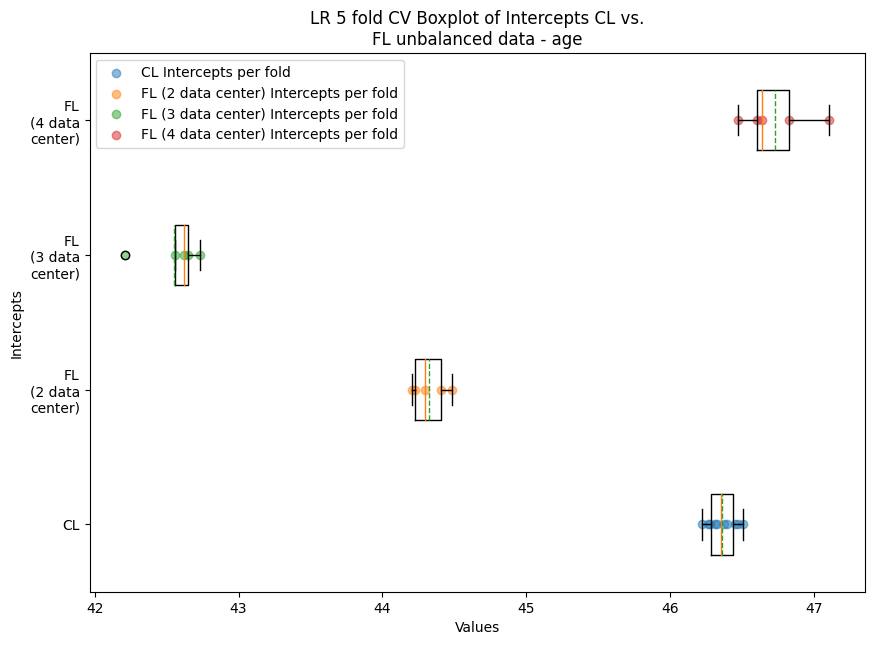

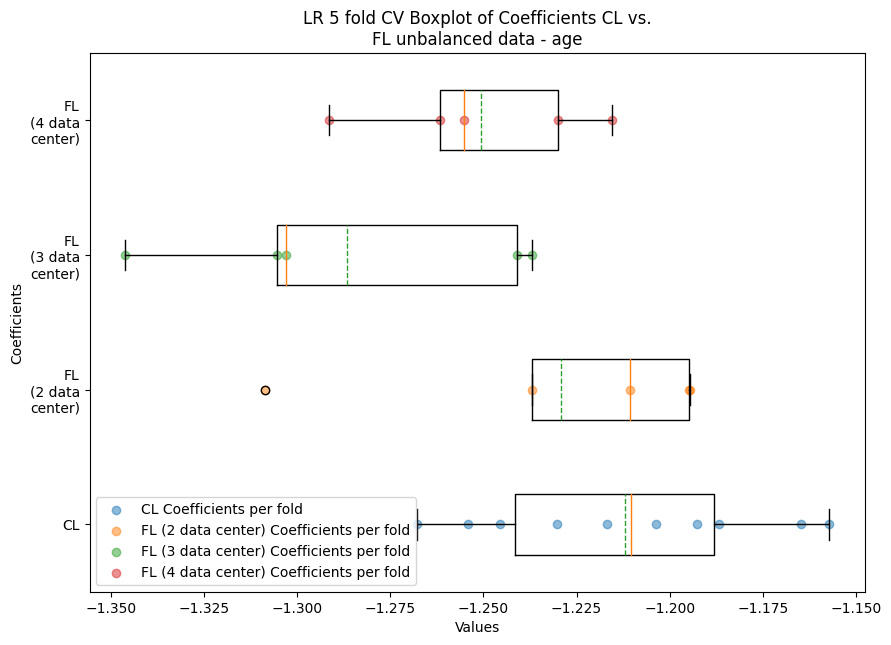

In [ ]:
labels = ['CL', 'FL\n(2 data\ncenter)', 'FL\n(3 data\ncenter)', 'FL\n(4 data\ncenter)']
legend_label = ['CL', 'FL (2 data center)', 'FL (3 data center)', 'FL (4 data center)']
title_inter = "LR 5 fold CV Boxplot of Intercepts CL vs.\nFL unbalanced data - age"
title_coef = "LR 5 fold CV Boxplot of Coefficients CL vs.\nFL unbalanced data - age"

plot_boxplot([CL_intercepts, intercept_2c, intercept_3c, intercept_4c]
             , labels, ylabel='Intercepts', outdir=outdir_plot, title=title_inter
             , legend_loc='upper left', legend_label=legend_label, save_img='intercept_age_LR.png')

plot_boxplot([CL_coefficients, coef_2c, coef_3c, coef_4c]
             , labels, ylabel='Coefficients', outdir=outdir_plot, title=title_coef
             , legend_loc='lower left', legend_label=legend_label, save_img='coefs_age_LR.png')

UNBALANCED DATA - CASP

In [ ]:
r2_2c, intercept_2c, coef_2c = load_FL_data('./drive/MyDrive/master_thesis/FL_casp_2c.txt')
print("FL_r2:", np.mean(r2_2c))
print("FL Intercept:", np.mean(intercept_2c))
print("FL coef:", np.mean(coef_2c))

r2_3c, intercept_3c, coef_3c = load_FL_data('./drive/MyDrive/master_thesis/FL_casp_3c.txt')
print("FL_r2:", np.mean(r2_3c))
print("FL Intercept:", np.mean(intercept_3c))
print("FL coef:", np.mean(coef_3c))

r2_4c, intercept_4c, coef_4c = load_FL_data('./drive/MyDrive/master_thesis/FL_casp_4c.txt')
print("FL_r2:", np.mean(r2_4c))
print("FL Intercept:", np.mean(intercept_4c))
print("FL coef:", np.mean(coef_4c))

FL_r2: 0.024717872828292364
FL Intercept: 40.52000793334577
FL coef: -0.532832436
FL_r2: 0.034385312311086436
FL Intercept: 42.660860111733236
FL coef: -0.6575136159999999
FL_r2: 0.03646741625286887
FL Intercept: 43.27316753712167
FL coef: -0.736076074


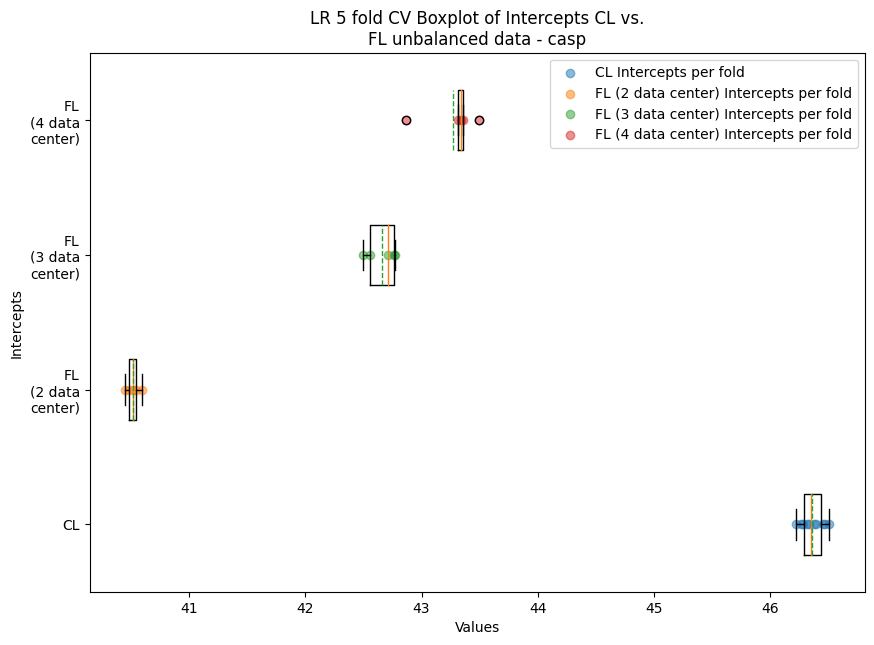

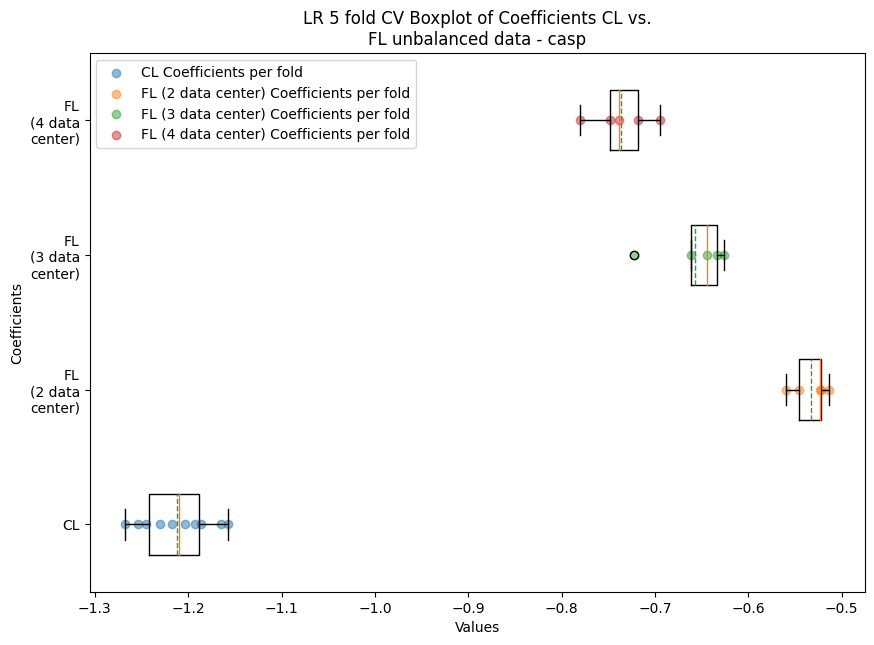

In [ ]:
title_inter = "LR 5 fold CV Boxplot of Intercepts CL vs.\nFL unbalanced data - casp"
title_coef = "LR 5 fold CV Boxplot of Coefficients CL vs.\nFL unbalanced data - casp"

plot_boxplot([CL_intercepts, intercept_2c, intercept_3c, intercept_4c]
             , labels, ylabel='Intercepts', outdir=outdir_plot, title=title_inter
             , legend_loc='upper right', legend_label=legend_label, save_img='intercepts_casp_LR.png')
plot_boxplot([CL_coefficients, coef_2c, coef_3c, coef_4c]
             , labels, ylabel='Coefficients', outdir=outdir_plot, title=title_coef
             , legend_loc='upper left', legend_label=legend_label, save_img='coefs_casp_LR.png')